<a href="https://colab.research.google.com/github/Yeon1A/KWHackathon/blob/main/EffNetB5_disease_e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### 라이브러리
!pip install tensorflow-addons

from tensorflow.keras.models import Model
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input,GlobalAveragePooling2D, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense, ZeroPadding2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import time
import math
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers

import random

from keras.preprocessing.image import ImageDataGenerator


os.environ['PYTHONHASHSEED']='1'
os.environ['TF_DETERMINISTIC_OPS']='1'
np.random.seed(5148)
random.seed(5148)
tf.random.set_seed(5148)




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 10.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
#%% GPU 할당

# GPU를 사용할 수 있는지 확인
#physical_devices = tf.config.list_physical_devices('GPU')
#if len(physical_devices) == 0:
#    print("GPU를 찾을 수 없습니다. CPU를 사용합니다.")
#else:
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)
#    print("GPU를 사용합니다.")


#%% GPU 할당

# GPU를 사용할 수 있는지 확인
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=10*1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)


In [ ]:
from google.colab import drive    # google drive mount
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%% B0 (224,224)

se_ratio = 4
expand_ratio = 6
#width_coefficient = 1.0 #B0
width_coefficient = 1.0 #B5 (456,456)

#depth_coefficient = 1.0 #B0
depth_coefficient = 2.2 #B5 (456,456)

#default_resolution = 224 #B0
default_resolution = 456 #B5

input_channels = 3
depth_divisor= 8

#dropout_rate = 0.2 #B0
dropout_rate = 0.4 #B5

drop_connect_rate = 0.2

In [ ]:
kernel_size = [3,3,5,3,5,5,3]
num_repeat = [1,2,2,3,3,4,1]
output_filters = [16,24,40,80,112,192,320]
strides = [1,2,2,2,1,2,1]
MBConvBlock_1_True  =  [True,False,False,False,False,False,False]


In [ ]:
def round_repeats(repeats, depth_coefficient):
    return int(math.ceil(depth_coefficient * repeats))

def round_filters(filters, width_coefficient, depth_divisor):
    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)



In [ ]:
# DropConnect 레이어 구현
class DropConnect(layers.Layer):
    def __init__(self, drop_connect_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.drop_connect_rate = drop_connect_rate

    def call(self, inputs, training):
        def _drop_connect():
            keep_prob = 1.0 - self.drop_connect_rate

            batch_size = tf.shape(inputs)[0]
            random_tensor = keep_prob
            random_tensor += K.random_uniform([batch_size, 1, 1, 1], dtype=inputs.dtype)
            binary_tensor = tf.floor(random_tensor)
            output = tf.math.divide(inputs, keep_prob) * binary_tensor
            return output

        return K.in_train_phase(_drop_connect, inputs, training=training)


In [ ]:
#%% Squeeze-and-Excitation Block 함수 구현
def SEBlock(filters,reduced_filters):
    def _block(inputs):
        x = layers.GlobalAveragePooling2D()(inputs)
        x = layers.Reshape((1,1,x.shape[1]))(x)
        x = layers.Conv2D(reduced_filters, 1, 1)(x)
        x = tfa.activations.mish(x)
        x = layers.Conv2D(filters, 1, 1)(x)
        x = layers.Activation('sigmoid')(x)
        x = layers.Multiply()([x, inputs])
        return x
    return _block


In [ ]:
#%% MBConvBlock 함수 구현
def MBConvBlock(x,kernel_size, strides,drop_connect_rate,output_channels,MBConvBlock_1_True=False):
    output_channels = round_filters(output_channels,width_coefficient,depth_divisor)
    if MBConvBlock_1_True:
        block = layers.DepthwiseConv2D(kernel_size, strides,padding='same', use_bias=False)(x)
        block = layers.BatchNormalization()(block)
        block = tfa.activations.mish(block)
        block = SEBlock(x.shape[3],x.shape[3]/se_ratio)(block)
        block = layers.Conv2D(output_channels, (1,1), padding='same', use_bias=False)(block)
        block = layers.BatchNormalization()(block)
        return block

    channels = x.shape[3]
    expand_channels = channels * expand_ratio
    block = layers.Conv2D(expand_channels, (1,1), padding='same', use_bias=False)(x)
    block = layers.BatchNormalization()(block)
    block = tfa.activations.mish(block)
    block = layers.DepthwiseConv2D(kernel_size, strides,padding='same', use_bias=False)(block)
    block = layers.BatchNormalization()(block)
    block = tfa.activations.mish(block)
    block = SEBlock(expand_channels,channels/se_ratio)(block)
    block = layers.Conv2D(output_channels, (1,1), padding='same', use_bias=False)(block)
    block = layers.BatchNormalization()(block)
    if x.shape[3] == output_channels:
        block = DropConnect(drop_connect_rate)(block)
        block = layers.Add()([block, x])
    return block


In [ ]:
def EffNet(input_shape,num_classes):
    x_input = layers.Input(shape=(default_resolution,default_resolution,input_channels))
    x = layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), (3,3), 2,padding='same', use_bias=False)(x_input)
    x = layers.BatchNormalization()(x)
    x = tfa.activations.mish(x)
    num_blocks_total = sum(num_repeat)
    block_num = 0
    for i in range(len(kernel_size)):
        round_num_repeat = round_repeats(num_repeat[i], depth_coefficient)
        drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
        x = MBConvBlock(x,kernel_size[i],strides[i],drop_rate,output_filters[i],MBConvBlock_1_True = MBConvBlock_1_True[i])
        block_num += 1
        if round_num_repeat > 1:
            for bidx in range(round_num_repeat - 1):
                drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                x = MBConvBlock(x,kernel_size[i],1,drop_rate,output_filters[i],MBConvBlock_1_True = MBConvBlock_1_True[i])
                block_num += 1
    x = layers.Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,padding='same',use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tfa.activations.mish(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(num_classes,activation='softmax')(x)
    model = tf.keras.models.Model(inputs=x_input, outputs=x)
    return model


In [ ]:
#%% Parameter

#input_shape=(224,224,3) #이미지의 크기
input_shape=(456,456,3)
num_classes=2 #클래스의 숫자
disease=["e"]

## resnet50 모델 5개를 각각 5개의질병에 적용 (a,b,c,d,e)

model_e=EffNet(input_shape,num_classes)

#%% 모델 요약

model_e.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 456, 456, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 228, 228, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 228, 228, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
image_path="/content/drive/MyDrive/L_TL2/cat/eye/normal"

#윈도우에서 시행시에
#image_path="C:/Users/VSA/Desktop/L_TL2/cat/eye/normal"

In [ ]:
#categories 는 유/무 구별

categories=["Y","N"] #0이 Y 1이 N

(1719, 456, 456, 3)
(1719, 2)
(191, 456, 456, 3)
(191, 2)
Epoch 1/200
860/860 [==============================] - 255s 173ms/step - loss: 0.7851 - accuracy: 0.5236
Epoch 2/200
860/860 [==============================] - 149s 173ms/step - loss: 0.7312 - accuracy: 0.5003
Epoch 3/200
860/860 [==============================] - 148s 172ms/step - loss: 0.7133 - accuracy: 0.4945
Epoch 4/200
860/860 [==============================] - 148s 172ms/step - loss: 0.7069 - accuracy: 0.5143
Epoch 5/200
860/860 [==============================] - 149s 173ms/step - loss: 0.7003 - accuracy: 0.5207
Epoch 6/200
860/860 [==============================] - 149s 173ms/step - loss: 0.7022 - accuracy: 0.5003
Epoch 7/200
860/860 [==============================] - 149s 173ms/step - loss: 0.7036 - accuracy: 0.5003
Epoch 8/200
860/860 [==============================] - 148s 173ms/step - loss: 0.7010 - accuracy: 0.4857
Epoch 9/200
860/860 [==============================] - 148s 172ms/step - loss: 0.7053 - accuracy: 0.49

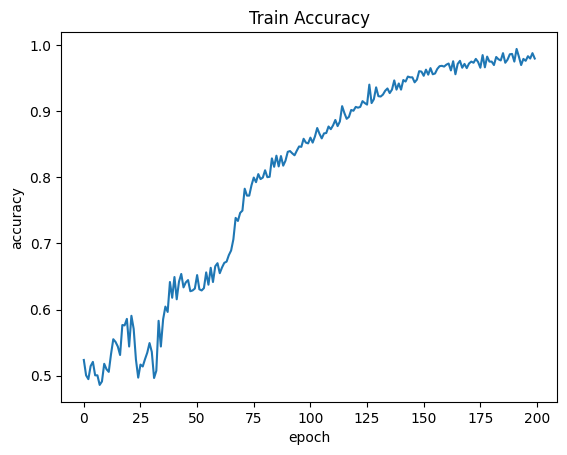

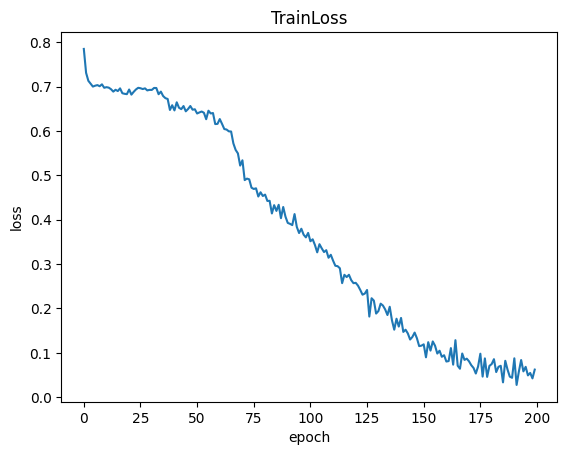

In [ ]:
#%% E모델 학습(안검염)

X=[]
Y=[]

for idx, cate in enumerate(categories):
    label = [0 for _ in range(num_classes)]
    label[idx] = 1
    image_dir = image_path + '/e/'+cate+'/'

    for top, dir, files in os.walk(image_dir):
        i = 0
        for filename in files:
            if filename[-4:] != 'json':
                i += 1
                img = cv2.imread(image_dir + filename, 1)
                #img = cv2.resize(img, (200, 200))
                img = cv2.copyMakeBorder(img, 28, 28, 28, 28, cv2.BORDER_CONSTANT, value=0) #Zero padding 400->456
                #img = cv2.copyMakeBorder(img, 12, 12, 12, 12, cv2.BORDER_CONSTANT, value=0)
                X.append(img)
                Y.append(label)

X=np.array(X)
X=X.astype(np.float32)/255.0
Y=np.array(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
model_e.compile(optimizer=Adam(learning_rate=0.0003),loss='categorical_crossentropy',metrics=['accuracy'])
with tf.device('/GPU:0'):
  history=model_e.fit(x_train,y_train,epochs=200,batch_size=2)
test_loss,test_acc=model_e.evaluate(x_test,y_test)
print("test accuracy:",test_acc)

plt.plot(history.history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['loss'])
plt.title('TrainLoss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model_e.save("/content/drive/MyDrive/model_e.h5")

model_e.save_weights("/content/drive/MyDrive/model_e_weight.h5")

In [ ]:
K.clear_session()